# TENSORFLOW - LSTM

Dans cette partie sur tensorflow, nous allons essayer d'améliorer les prédictions des modèles scikit learn en utilisant le modèle Long Short Term Memory ($LSTM$).

Le $LSTM$ est une variante des réseaux de neuronnes récurrent ($RNN$), c'est à dire que les neurones utilisent leur sortie comme un nouvel input.
Ce type de modèle est généralement exposé à l'explosion ou la disparition du gradient à cause de leur aspect récursif.

Cependant, le $LSTM$ permet de régler ce problème en instaurant une cellule d'état. Cette cellule comporte 3 portes : porte d'oublie (% de la mémoire long terme oubliée), la porte d'entrée (création d'une mémoire long terme) et porte de sortie (création de mémoire court terme). A chaque observation, le neurone met à jour l'état de la cellule afin de récupérer l'effet long terme (tendance par exemple) et l'effet court terme (de volatilité dans notre cas).

Le $LSTM$ est donc particulièrement utilisé pour effectuer des prédictions de séries temporelles et c'est ce pourquoi nous allons l'utiliser pour tenter d'améliorer les performances de nos modèles par rapport à la problématique. Pour rappel, nous devons prédire si le prix de clôture au terme du jour $N_{+1}$ va augmenter ou diminuer par rapport au jour $N$.

Pour ce faire, nous allons d'abord prédire le prix du lendemain grâce au $LSTM$, puis nous crérons des variables cibles pour mesurer la précision du modèle.

## presenter la formule des vars cibles (ici ou au début)

Nous allons d'abord utiliser seulement l'évolution de la variable Close_price, le prix de fermeture de chaque bougies po.
Nous utiliserons ensuite les autres variables permettant de créer les datasets v1 pour tenter d'améliorer le modèle.

<font color='RED'>**A TERMINER**</font>


## <font color='RED'>PRÉSENTATION DU MODÈLE</font>

Le réseau de neuronnes LSTM est composé de plusieurs couches. Une première couche d'input pour spécifier la forme de notre jeu de données en entrée. En effet, ce réseau de neuronnes demande un mise en forme particulière. Le jeu d'entrée est de dimension trois. Pour cette raison nous devons en préciser 2 à savoir la taille de la fenêtre (window_size) et le nombre de variable (n_features), la troisième étant les observations.

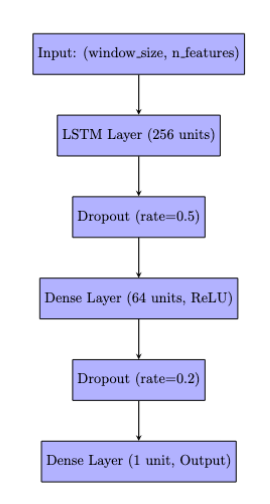

### Présentation des fonctions de preprocessing, training et analyse

In [191]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from dotenv import load_dotenv
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score, max_error, mean_absolute_percentage_error
from sklearn.metrics import confusion_matrix, roc_curve, auc, accuracy_score, precision_score, recall_score
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import LSTM, Input, Dense, Dropout
from tensorflow.keras.callbacks import ModelCheckpoint
from tensorflow.keras.losses import MeanSquaredError
from tensorflow.keras.metrics import RootMeanSquaredError
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.models import load_model

load_dotenv()

WD = os.getenv('working_directory')

#### Pre processing

In [192]:
######### Fonctions de preprocessing communes au modèle pour une ou plusieurs variables #########

def load_data(name):
    """
    Charge un dataframe depuis un fichier CSV situé dans le répertoire data.

    Args:
        name (str): Nom du fichier CSV (sans extension).

    Returns:
        pandas.DataFrame: Le dataframe chargé depuis le fichier.
    """
    return pd.read_csv(f'{WD}/data/{name}.csv')

def get_close_price(df):
    """
    Extrait le prix de clôture depuis un dataframe.

    Args:
        df (pandas.DataFrame): Dataframe contenant une colonne 'Close_price'.

    Returns:
        pandas.Series: Série contenant les prix de clôture.
    """
    return df['Close_price'].copy()

def get_log_close_price(df):
    """
    Extrait le logarithme naturel du prix de clôture depuis un dataframe.

    Args:
        df (pandas.DataFrame): Dataframe contenant une colonne 'Close_price'.

    Returns:
        pandas.Series: Série contenant le logarithme naturel des prix de clôture.
    """
    return np.log(df['Close_price'].copy())

def get_date(df):
    """
    Extrait les dates d'ouverture depuis un dataframe.

    Args:
        df (pandas.DataFrame): Dataframe contenant une colonne 'Open_time'.

    Returns:
        pandas.Series: Série contenant les dates d'ouverture.
    """
    return df['Open_time'].copy()

def df_to_numpy(df):
    """
    Convertit un dataframe en matrice NumPy.

    Args:
        df (pandas.DataFrame): Dataframe à convertir.

    Returns:
        numpy.ndarray: Matrice NumPy contenant les données du dataframe.
    """
    return df.to_numpy()

def train_test_val(X, y, date, train_size):
    """
    Sépare les données en ensembles d'entraînement, de validation et de test.

    Args:
        X (numpy.ndarray): Caractéristiques (features).
        y (numpy.ndarray): Prix cibles
        date (pandas.Series): Dates
        train_size (float): Proportion des données utilisées pour l'entraînement (entre 0 et 1).

    Returns:
        tuple: Contient les ensembles séparés :
            - date_train, X_train, y_train (entraînement),
            - date_val, X_val, y_val (validation),
            - date_test, X_test, y_test (test).
    """
    q_train_size = int(len(X) * train_size)
    q_val_test_size = int(len(X) * (train_size + (1 - train_size) / 2))
    date_numpy = df_to_numpy(date)

    X_train, y_train, date_train = X[:q_train_size], y[:q_train_size], date_numpy[:q_train_size]
    X_val, y_val, date_val = X[q_train_size:q_val_test_size], y[q_train_size:q_val_test_size], date_numpy[q_train_size:q_val_test_size]
    X_test, y_test, date_test = X[q_val_test_size:], y[q_val_test_size:], date_numpy[q_val_test_size:]

    return date_train, X_train, y_train, date_val, X_val, y_val, date_test, X_test, y_test

def normalization(X, y):
    """
    Normalise les données à l'aide de MinMaxScaler.

    Args:
        X (numpy.ndarray): Données d'entrée multi-dimensionnelles.
        y (numpy.ndarray): Données de sortie (labels).

    Returns:
        tuple: Contient les données normalisées et le scaler utilisé :
            - X_train_scaled (numpy.ndarray): Données normalisées pour X.
            - y_train_scaled (numpy.ndarray): Données normalisées pour y.
            - scaler (sklearn.preprocessing.MinMaxScaler): Scaler utilisé pour la normalisation.
    """
    scaler = MinMaxScaler(feature_range=(0, 1))
    X_train_scaled = scaler.fit_transform(X.reshape(-1, X.shape[-1])).reshape(X.shape)
    y_train_scaled = scaler.fit_transform(y.reshape(-1, 1))

    return X_train_scaled, y_train_scaled, scaler

######################## Fonctions propres à une variable ########################

def window_matrix_one_var(df, window_size):
    """
    Construit une matrice pour une variable unique en utilisant une fenêtre glissante.

    Args:
        df (pandas.DataFrame): Dataframe contenant la variable à traiter.
        window_size (int): Taille de la fenêtre glissante.

    Returns:
        tuple: Contient les matrices X et y :
            - X (numpy.ndarray): Matrice contenant les fenêtres (a, b, c) où :
                a = # observations,
                b = window_size,
                c = 1 (variable unique).
            - y (numpy.ndarray): Labels associés (valeur suivante après chaque fenêtre).
    """
    df_numpy = df_to_numpy(df).reshape(len(df), -1)
    X = []
    y = []
    for i in range(len(df_numpy) - window_size):
        row = [a for a in df_numpy[i:i + window_size]]
        X.append(row)
        y.append(df_numpy[i + window_size])

    return np.array(X).astype(np.float32), np.array(y).astype(np.float32)

######################## Fonctions propres à plusieurs variables ########################

def formatting_data(df):
    """
    Prépare les données pour le preprocessing en mettant les colonnes au bon format pour les datasets_v2*

    Args:
        df (pandas.DataFrame): Dataframe brut contenant les données.

    Returns:
        tuple: Contient les données formatées :
            - date (pandas.Series): Série contenant les dates extraites.
            - df (pandas.DataFrame): Dataframe avec les colonnes formatées.
    """
    df.dropna(inplace=True)
    df['log_close_price'] = pd.Series(get_log_close_price(df))
    df.rename(columns={'date_utc': 'Open_time'}, inplace=True)
    date = get_date(df)
    df.drop('Open_time', axis=1, inplace=True)
    df.drop('Close_price', axis=1, inplace=True)

    # Positionne Close_price en premier pour faciliter l'identification dans la matrice (a,b,c)
    columns = ['log_close_price'] + [col for col in df.columns if col != 'log_close_price']
    df = df[columns]

    return date, df

def window_matrix_multi_var(df, window_size):
    """
    Construit une matrice pour plusieurs variables en utilisant une fenêtre glissante.

    Args:
        df (pandas.DataFrame): Dataframe contenant plusieurs variables.
        window_size (int): Taille de la fenêtre glissante.

    Returns:
        tuple: Contient les matrices X et y :
            - X (numpy.ndarray): Matrice contenant les fenêtres (a, b, c) où :
                a = # observations,
                b = window_size,
                c = # variables.
            - y (numpy.ndarray): Labels associés (valeurs de la première colonne après chaque fenêtre).
    """
    df_numpy = df_to_numpy(df).reshape(len(df), -1)
    X = []
    y = []
    for i in range(len(df_numpy) - window_size):
        row = [a for a in df_numpy[i:i + window_size]]
        X.append(row)
        y.append(df_numpy[i + window_size][0])  # Récupère la première colonne

    return np.array(X).astype(np.float32), np.array(y).astype(np.float32)


In [193]:
######### Fonctions main #########

def main_pre_processing_close_price(name, window_size):
    """
    Prétraitement des données pour une seule variable : le prix de clôture.

    Args:
        name (str): Nom du fichier CSV contenant les données (sans extension).
        window_size (int): Taille de la fenêtre temporelle utilisée pour créer les séquences.

    Returns:
        dict: Contient les datasets prétraités pour l'entraînement, la validation et le test.
              Chaque clé ('TRAIN', 'TEST', 'VAL') mappe une liste [date, X_norm, y_norm, scaler].
    """
    df = load_data(name)
    date = get_date(df)
    df_close_price = get_close_price(df)
    X, y = window_matrix_one_var(df_close_price, window_size)
    date_train, X_train, y_train, date_val, X_val, y_val, date_test, X_test, y_test = train_test_val(X, y, date, 0.8)

    print("X.shape", X.shape)
    print("y.shape", y.shape)

    datasets = {}

    # TRAIN
    X_train_norm, y_train_norm, scaler_train = normalization(X_train, y_train)
    datasets['TRAIN'] = [[date_train, X_train_norm, y_train_norm, scaler_train]]
    print("X_train_norm.shape", X_train_norm.shape)
    print("y_train_norm.shape", y_train_norm.shape)

    # TEST
    X_test_norm, y_test_norm, scaler_test = normalization(X_test, y_test)
    datasets['TEST'] = [[date_test, X_test_norm, y_test_norm, scaler_test]]

    # VAL
    X_val_norm, y_val_norm, scaler_val = normalization(X_val, y_val)
    datasets['VAL'] = [[date_val, X_val_norm, y_val_norm, scaler_val]]

    return datasets

def main_pre_processing_log_close_price(name, window_size):
    """
    Prétraitement des données pour une seule variable : le prix de clôture (logarithmique).

    Args:
        name (str): Nom du fichier CSV contenant les données (sans extension).
        window_size (int): Taille de la fenêtre temporelle utilisée pour créer les séquences.

    Returns:
        dict: Contient les datasets prétraités pour l'entraînement, la validation et le test.
              Chaque clé ('TRAIN', 'TEST', 'VAL') mappe une liste [date, X_norm, y_norm, scaler].
    """
    df = load_data(name)
    date = get_date(df)
    df_log_close_price = get_log_close_price(df)
    X, y = window_matrix_one_var(df_log_close_price, window_size)
    date_train, X_train, y_train, date_val, X_val, y_val, date_test, X_test, y_test = train_test_val(X, y, date, 0.8)

    print("X.shape", X.shape)
    print("y.shape", y.shape)

    datasets = {}

    # TRAIN
    X_train_norm, y_train_norm, scaler_train = normalization(X_train, y_train)
    datasets['TRAIN'] = [[date_train, X_train_norm, y_train_norm, scaler_train]]
    print("X_train_norm.shape", X_train_norm.shape)
    print("y_train_norm.shape", y_train_norm.shape)

    # TEST
    X_test_norm, y_test_norm, scaler_test = normalization(X_test, y_test)
    datasets['TEST'] = [[date_test, X_test_norm, y_test_norm, scaler_test]]

    # VAL
    X_val_norm, y_val_norm, scaler_val = normalization(X_val, y_val)
    datasets['VAL'] = [[date_val, X_val_norm, y_val_norm, scaler_val]]

    return datasets

def main_pre_processing_multivar(name, window_size):
    """
    Prétraitement des données pour plusieurs variables 
    dont le log_close_price à la place du close_price

    Args:
        name (str): Nom du fichier CSV contenant les données (sans extension).
        window_size (int): Taille de la fenêtre temporelle utilisée pour créer les séquences.

    Returns:
        dict: Contient les datasets prétraités pour l'entraînement, la validation et le test.
              Chaque clé ('TRAIN', 'TEST', 'VAL') mappe une liste [date, X_norm, y_norm, scaler].
    """
    df = load_data(name)
    date, formated_df = formatting_data(df)
    print(formated_df.columns)
    X, y = window_matrix_multi_var(formated_df, window_size)
    date_train, X_train, y_train, date_val, X_val, y_val, date_test, X_test, y_test = train_test_val(X, y, date, 0.8)

    print("X.shape", X.shape)
    print("y.shape", y.shape)

    datasets = {}

    # TRAIN
    X_train_norm, y_train_norm, scaler_train = normalization(X_train, y_train)
    datasets['TRAIN'] = [[date_train, X_train_norm, y_train_norm, scaler_train]]
    print("X_train_norm.shape", X_train_norm.shape)
    print("y_train_norm.shape", y_train_norm.shape)

    # TEST
    X_test_norm, y_test_norm, scaler_test = normalization(X_test, y_test)
    datasets['TEST'] = [[date_test, X_test_norm, y_test_norm, scaler_test]]

    # VAL
    X_val_norm, y_val_norm, scaler_val = normalization(X_val, y_val)
    datasets['VAL'] = [[date_val, X_val_norm, y_val_norm, scaler_val]]

    return datasets


#### Training

In [194]:
######### Fonctions de training communes au modèle pour une ou plusieurs variables #########

def prepare_model(name, n_features, window_size):
    """
    Construit la structure du modèle de réseau de neurones séquentiel avec des couches LSTM et Dense.

    Args:
        name (str): Nom du modèle.
        n_features (int): Nombre de caractéristiques (features) en entrée.
        window_size (int): Taille de la fenêtre temporelle (nombre de pas de temps).

    Returns:
        keras.Model: Modèle séquentiel construit avec les spécifications fournies.
    """
    model = Sequential(
        [
            Input((window_size, n_features)),
            LSTM(256),
            Dropout(0.5),
            Dense(64, activation='relu'),
            Dropout(0.2),
            Dense(1)
        ], 
        name=name
    )
    return model

def prepare_checkpoint(name):
    """
    Prépare un callback pour sauvegarder le modèle au cours de l'entraînement.

    Args:
        name (str): Nom du modèle, utilisé pour définir le chemin de sauvegarde.

    Returns:
        keras.callbacks.ModelCheckpoint: Callback de sauvegarde configuré pour conserver 
        uniquement la meilleure version du modèle selon la métrique 'loss'.
    """
    return ModelCheckpoint(
        f'{WD}/src/model/models/{name}/', 
        save_best_only=True, 
        save_format='tf', 
        monitor='loss'
    )

def compile(model, learning_rate):
    """
    Configure le modèle pour l'entraînement en spécifiant la fonction de perte, l'optimiseur, et les métriques.

    Args:
        model (keras.Model): Modèle à compiler.
        learning_rate (float): Taux d'apprentissage pour l'optimiseur Adam.

    Returns:
        keras.Model: Modèle compilé prêt pour l'entraînement.
    """
    model.compile(
        loss=MeanSquaredError(), 
        optimizer=Adam(learning_rate=learning_rate), 
        metrics=[RootMeanSquaredError()]
    )
    return model

def fit(model, cp, X_train, y_train, X_val, y_val, N_EPOCHS):
    """
    Entraîne le modèle en utilisant les ensembles d'entraînement et de validation.

    Args:
        model (keras.Model): Modèle à entraîner.
        cp (keras.callbacks.ModelCheckpoint): Callback pour sauvegarder le modèle pendant l'entraînement.
        X_train (numpy.ndarray): Données d'entrée pour l'entraînement.
        y_train (numpy.ndarray): Labels pour l'entraînement.
        X_val (numpy.ndarray): Données d'entrée pour la validation.
        y_val (numpy.ndarray): Labels pour la validation.
        N_EPOCHS (int): Nombre d'époques d'entraînement.

    Returns:
        keras.Model: Modèle entraîné.
    """
    model.fit(
        X_train, 
        y_train, 
        validation_data=(X_val, y_val), 
        epochs=N_EPOCHS, 
        callbacks=[cp]
    )
    return model

def main_training_model(model_name, X_train, y_train, X_val, y_val, window_size, N_EPOCHS):
    """
    Fonction principale pour entraîner un modèle.

    Args:
        model_name (str): Nom du modèle pour sauvegarde et identification.
        X_train (numpy.ndarray): Données d'entrée pour l'entraînement, de forme (échantillons, fenêtres, variables).
        y_train (numpy.ndarray): Cibles correspondantes pour l'entraînement.
        X_val (numpy.ndarray): Données d'entrée pour la validation.
        y_val (numpy.ndarray): Cibles correspondantes pour la validation.
        window_size (int): Taille de la fenêtre temporelle utilisée comme entrée du modèle.
        N_EPOCHS (int): Nombre d'époques d'entraînement.

    Returns:
        keras.Model: Modèle entraîné.
    """
    # Préparation du checkpoint pour sauvegarder le modèle
    cp = prepare_checkpoint(name=model_name)
    
    # Construction du modèle
    model = prepare_model(name=model_name, n_features=X_train.shape[2], window_size=window_size)
    
    # Compilation du modèle
    model = compile(model, 0.001)
    
    # Entraînement du modèle
    model = fit(model, cp, X_train, y_train, X_val, y_val, N_EPOCHS)
    
    return model



#### Analyse

In [195]:
######### Fonctions d'analyse communes au modèle pour une ou plusieurs variables #########

def create_directory_if_not_exists(directory_name):
    """
    Crée un répertoire s'il n'existe pas déjà.

    Args:
        directory_name (str): Le nom du répertoire à créer.

    Returns:
        None
    """
    if not os.path.exists(directory_name):
        try:
            os.makedirs(directory_name)
            print(f"Répertoire '{directory_name}' créé avec succès.")
        except Exception as e:
            print(f"Erreur lors de la création du répertoire '{directory_name}': {e}")
    else:
        print(f"Le répertoire '{directory_name}' existe déjà.")

def load(name):
    """
    Charge un modèle préalablement sauvegardé.

    Args:
        name (str): Nom du modèle à charger.

    Returns:
        keras.Model: Modèle chargé avec les objets personnalisés nécessaires (comme LSTM).
    """
    return load_model(f'{WD}/src/model/models/{name}/', custom_objects={'LSTM': LSTM})

def predict(model, X):
    """
    Effectue une prédiction à partir des données fournies.

    Args:
        model (keras.Model): Modèle utilisé pour effectuer les prédictions.
        X (numpy.ndarray): Données d'entrée pour la prédiction.

    Returns:
        numpy.ndarray: Résultats des prédictions.
    """
    return model.predict(X)

def inverse_scaler(scaler, array):
    """
    Applique l'inverse de la normalisation sur un tableau de données.

    Args:
        scaler (sklearn.preprocessing.MinMaxScaler): Scaler utilisé pour normaliser les données.
        array (numpy.ndarray): Données normalisées à inverser.

    Returns:
        numpy.ndarray: Données après inversion de la normalisation.
    """
    return scaler.inverse_transform(array)

def plot(df, model_name, data_type):
    """
    Affiche et sauvegarde un graphique comparant les valeurs réelles et prédites.

    Args:
        df (pandas.DataFrame): Contient les colonnes 'Date', 'Actual N+8', et 'Predictions N+8'.
        model_name (str): Nom du modèle, utilisé pour nommer les fichiers de sortie.
        data_type (str): Type de données (ex: 'train', 'test', ou 'val').

    Returns:
        None
    """
    ticks_to_display = np.linspace(0, len(df) - 1, 5, dtype=int)  # 5 indices répartis uniformément
    create_directory_if_not_exists(f'{WD}/figure/{model_name}')
    plt.clf()
    plt.plot(df['Date'], df['Actual N+8'], label='Actuals') 
    plt.plot(df['Date'], df['Predictions N+8'], label='Predictions')
    plt.xticks(ticks_to_display, df["Date"].iloc[ticks_to_display], rotation=45)
    plt.title(f"Comparaison Réel et Prédiction pour le jeu de {data_type}")
    plt.legend()
    plt.savefig(f"{WD}/figure/{model_name}/COMPARAISON_{data_type}_prediction.png")
    plt.show()

def table(date, X_inv_scaled, y_inv_scaled, y_pred_inv_scaled, window_size):
    """
    Construit le tableau d'analyse des résultats.

    Args:
        date (numpy.ndarray): Dates des observations.
        X_inv_scaled (numpy.ndarray): Données d'entrée après inversion de la normalisation.
        y_inv_scaled (numpy.ndarray): Valeurs réelles après inversion de la normalisation.
        y_pred_inv_scaled (numpy.ndarray): Valeurs prédites après inversion de la normalisation.

    Returns:
        pandas.DataFrame: Tableau d'analyse structuré.
    """
    df_analyze = pd.concat([
        pd.DataFrame(date),
        pd.DataFrame(X_inv_scaled[:, window_size-1, 0]),
        pd.DataFrame(y_inv_scaled.reshape(-1)),
        pd.DataFrame(y_pred_inv_scaled)
    ], axis=1).dropna()
    df_analyze.columns = ['Date', 'Actual N+7', 'Actual N+8', 'Predictions N+8']

    # Crée les variables dichotomiques targets pour les vraies valeurs et les prédictions
    df_analyze['Actual UP or DOWN'] = (df_analyze['Actual N+8'] > df_analyze['Actual N+7']).astype(int)
    df_analyze['Predicted UP or DOWN'] = (df_analyze['Predictions N+8'] > df_analyze['Actual N+7']).astype(int)
    
    return df_analyze

def table_log(date, X_inv_scaled, y_inv_scaled, y_pred_inv_scaled, window_size):
    """
    Construit le tableau d'analyse des résultats.

    Args:
        date (numpy.ndarray): Dates des observations.
        X_inv_scaled (numpy.ndarray): Données d'entrée après inversion de la normalisation.
        y_inv_scaled (numpy.ndarray): Valeurs réelles après inversion de la normalisation.
        y_pred_inv_scaled (numpy.ndarray): Valeurs prédites après inversion de la normalisation.

    Returns:
        pandas.DataFrame: Tableau d'analyse structuré.
    """
    df_analyze = pd.concat([
        pd.DataFrame(date),
        pd.DataFrame(np.exp(X_inv_scaled[:, window_size-1, 0])),
        pd.DataFrame(np.exp(y_inv_scaled.reshape(-1))),
        pd.DataFrame(np.exp(y_pred_inv_scaled))
    ], axis=1).dropna()
    df_analyze.columns = ['Date', 'Actual N+7', 'Actual N+8', 'Predictions N+8']

    # Crée les variables dichotomiques targets pour les vraies valeurs et les prédictions
    df_analyze['Actual UP or DOWN'] = (df_analyze['Actual N+8'] > df_analyze['Actual N+7']).astype(int)
    df_analyze['Predicted UP or DOWN'] = (df_analyze['Predictions N+8'] > df_analyze['Actual N+7']).astype(int)
    
    return df_analyze

def R2(df_analyze):
    """
    Calcule le coefficient de détermination (R^2).

    Args:
        df_analyze (pandas.DataFrame): Tableau d'analyse.

    Returns:
        float: Coefficient de détermination (R^2) en pourcentage.
    """
    return r2_score(df_analyze['Actual N+8'].values, df_analyze['Predictions N+8'].values) * 100

def MAE(df_analyze):
    """
    Calcule l'erreur absolue moyenne (MAE) entre les valeurs réelles et les prédictions.

    Parameters:
    ----------
    df_analyze : pandas.DataFrame
        Un DataFrame contenant les colonnes 'Actual N+8' (valeurs réelles) et 
        'Predictions N+8' (valeurs prédites).

    Returns:
    -------
    float
        L'erreur absolue moyenne (Mean Absolute Error) entre les valeurs réelles et les valeurs prédites.
    """
    return mean_absolute_error(df_analyze['Actual N+8'].values, df_analyze['Predictions N+8'].values)

def MSE(df_analyze):
    """
    Calcule l'erreur quadratique moyenne (MSE) et la racine de l'erreur quadratique moyenne (RMSE) 
    pour comparer les valeurs réelles et les prédictions.

    Parameters:
    ----------
    df_analyze : pandas.DataFrame
        Un DataFrame contenant les colonnes 'Actual N+8' (valeurs réelles) et 
        'Predictions N+8' (valeurs prédites).

    Returns:
    -------
    tuple
        mse : float
            Erreur quadratique moyenne (Mean Squared Error).
        rmse : float
            Racine de l'erreur quadratique moyenne (Root Mean Squared Error).
    """
    mse = mean_squared_error(df_analyze['Actual N+8'].values, df_analyze['Predictions N+8'].values)
    rmse = np.sqrt(mse)
    return mse, rmse

def MAPE(df_analyze):
    """
    Calcule le pourcentage d'erreur absolue moyenne (MAPE) pour évaluer la précision des prédictions.

    Parameters:
    ----------
    df_analyze : pandas.DataFrame
        Un DataFrame contenant les colonnes 'Actual N+8' (valeurs réelles) et 
        'Predictions N+8' (valeurs prédites).

    Returns:
    -------
    float
        Le pourcentage d'erreur absolue moyenne (Mean Absolute Percentage Error) en pourcentage.
    """
    return mean_absolute_percentage_error(df_analyze['Actual N+8'].values, df_analyze['Predictions N+8'].values) * 100

def MAX_ERROR(df_analyze):
    """
    Calcule l'erreur absolue maximale entre les valeurs réelles et les prédictions.

    Parameters:
    ----------
    df_analyze : pandas.DataFrame
        Un DataFrame contenant les colonnes 'Actual N+8' (valeurs réelles) et 
        'Predictions N+8' (valeurs prédites).

    Returns:
    -------
    float
        L'erreur absolue maximale entre les valeurs réelles et les valeurs prédites.
    """
    return max_error(df_analyze['Actual N+8'].values, df_analyze['Predictions N+8'].values)

def CM(df_analyze):
    """
    Construit la matrice de confusion et calcule la précision.

    Args:
        df_analyze (pandas.DataFrame): Tableau d'analyse.

    Returns:
        tuple:
            - cm_df (pandas.DataFrame): Matrice de confusion.
            - accuracy (float): Précision en pourcentage.
    """
    cm = confusion_matrix(df_analyze['Actual UP or DOWN'], df_analyze['Predicted UP or DOWN'])
    cm_df = pd.DataFrame(cm, index=['Actual DOWN', 'Actual UP'], columns=['Predicted DOWN', 'Predicted UP'])
    return cm_df

def ACCURACY(df_analyze):
    """
    Calcule l'accuracy (exactitude) entre les valeurs réelles et les prédictions.

    Parameters:
    ----------
    df_analyze : pandas.DataFrame
        Un DataFrame contenant les colonnes 'Actual N+8' (valeurs réelles) et 
        'Predictions N+8' (valeurs prédites).

    Returns:
    -------
    float
        L'accuracy (exactitude) entre les valeurs réelles et les prédictions.
    """
    return accuracy_score(df_analyze['Actual UP or DOWN'], df_analyze['Predicted UP or DOWN'])*100

def PRECISION(df_analyze):
    """
    Calcule la précision des prédictions en fonction des valeurs réelles.

    Parameters:
    ----------
    df_analyze : pandas.DataFrame
        Un DataFrame contenant les colonnes 'Actual N+8' (valeurs réelles) et 
        'Predictions N+8' (valeurs prédites).

    Returns:
    -------
    float
        La précision des prédictions (Fraction des prédictions positives correctes).
    """
    return precision_score(df_analyze['Actual UP or DOWN'], df_analyze['Predicted UP or DOWN'])*100

def RECALL(df_analyze):
    """
    Calcule le rappel des prédictions en fonction des valeurs réelles.

    Parameters:
    ----------
    df_analyze : pandas.DataFrame
        Un DataFrame contenant les colonnes 'Actual N+8' (valeurs réelles) et 
        'Predictions N+8' (valeurs prédites).

    Returns:
    -------
    float
        Le rappel des prédictions (Fraction des éléments réels positifs retrouvés).
    """
    return recall_score(df_analyze['Actual UP or DOWN'], df_analyze['Predicted UP or DOWN'])*100

def ROC_AUC(df_analyze):
    """
    Calcule l'aire sous la courbe ROC (Receiver Operating Characteristic) et 
    retourne les valeurs nécessaires pour tracer la courbe ROC.

    Parameters:
    ----------
    df_analyze : pandas.DataFrame
        Un DataFrame contenant :
        - 'Actual UP or DOWN' : les valeurs réelles (1 pour UP, 0 pour DOWN).
        - 'Predicted UP or DOWN' : les prédictions du modèle (1 pour UP, 0 pour DOWN).

    Returns:
    -------
    roc_auc : float
        L'aire sous la courbe ROC (AUC), qui mesure la capacité du modèle à séparer 
        les classes positives et négatives.
    fpr : array-like
        Taux de faux positifs (False Positive Rates), calculés à différents seuils.
    tpr : array-like
        Taux de vrais positifs (True Positive Rates), calculés à différents seuils.

    Example:
    -------
    >>> roc_auc, fpr, tpr = ROC_AUC(df_analyze)
    >>> print(f"AUC: {roc_auc}")
    >>> PLOT_ROC(fpr, tpr)
    """
    fpr, tpr, thresholds = roc_curve(df_analyze['Actual UP or DOWN'], df_analyze['Predicted UP or DOWN'])
    roc_auc = auc(fpr, tpr)

    return roc_auc, fpr, tpr

def PLOT_ROC(roc_auc, fpr, tpr):
    """
    Affiche la courbe ROC (Receiver Operating Characteristic) en fonction des taux 
    de faux positifs (FPR) et des taux de vrais positifs (TPR).

    Parameters:
    ----------
    fpr : array-like
        Taux de faux positifs (False Positive Rates), calculés à différents seuils.
    tpr : array-like
        Taux de vrais positifs (True Positive Rates), calculés à différents seuils.

    Returns:
    -------
    None
        La fonction affiche la courbe ROC avec des informations graphiques, telles que 
        une ligne de référence et des axes étiquetés.
    """
    plt.figure()
    plt.plot(fpr, tpr, color='darkorange', lw=2, label='Courbe ROC (AUC = %0.2f)' % roc_auc)
    plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('Taux de Faux Positifs (FPR)')
    plt.ylabel('Taux de Vrais Positifs (TPR)')
    plt.title('Courbe ROC')
    plt.legend(loc="lower right")
    plt.show()

def analyze_table(date, X, y, y_pred, scaler, window_size, is_log):
    """
    Analyse les résultats des prédictions en générant un tableau d'analyse, 
    le coefficient de détermination (R^2), et une matrice de confusion.

    Args:
        date (numpy.ndarray): Dates correspondant aux observations.
        X (numpy.ndarray): Données d'entrée originales.
        y (numpy.ndarray): Valeurs réelles.
        y_pred (numpy.ndarray): Valeurs prédites.
        scaler (sklearn.preprocessing.MinMaxScaler): Scaler utilisé pour la normalisation des données.
        window_size (int): Taille de la fenêtre temporelle.

    Returns:
        tuple: 
            - df_analyze (pandas.DataFrame): Tableau contenant les résultats d'analyse.
            - r2 (float): Coefficient de détermination (R^2).
            - cm (pandas.DataFrame): Matrice de confusion.
            - accuracy (float): Précision du modèle en pourcentage.
    """

    # X Reshape et inverse scaling
    X_reshape = X.reshape(X.shape[0], -1)
    X_inv_scaled_reshape = np.array(inverse_scaler(scaler, X_reshape))
    X_inv_scaled = X_inv_scaled_reshape.reshape(X.shape)

    # y et y_pred inverse scaling
    y_inv_scaled = inverse_scaler(scaler, y)
    y_pred_inv_scaled = inverse_scaler(scaler, y_pred)
    
    # Analyse
    if is_log:
        df_analyze = table_log(date, X_inv_scaled, y_inv_scaled, y_pred_inv_scaled, window_size)
    else:
        df_analyze = table(date, X_inv_scaled, y_inv_scaled, y_pred_inv_scaled, window_size)
    r2 = R2(df_analyze)
    mae = MAE(df_analyze)
    mse, rmse = MSE(df_analyze)
    mape = MAPE(df_analyze)
    max_error = MAX_ERROR(df_analyze)
    cm = CM(df_analyze)
    accuracy = ACCURACY(df_analyze)
    precision = PRECISION(df_analyze)
    recall = RECALL(df_analyze)
    auc, fpr, tpr = ROC_AUC(df_analyze)

    return df_analyze, r2, mae, mse, rmse, mape, max_error, cm, accuracy, precision, recall, auc, fpr, tpr

def analyze(model, data_type, datasets, window_size, is_log):
    """
    Analyse un ensemble de données avec le modèle fourni et génère des métriques et graphiques.

    Args:
        model (keras.Model): Modèle à utiliser pour la prédiction.
        data_type (str): Type de données ('train', 'test', ou 'val').
        datasets (dict): Dictionnaire contenant les ensembles de données.
        window_size (int): Taille de la fenêtre temporelle.

    Returns:
        None
    """
    date = datasets[data_type][0][0]
    X = datasets[data_type][0][1]
    y = datasets[data_type][0][2]
    scaler = datasets[data_type][0][3]

    y_pred = predict(model, X)

    df_analyze, r2, mae, mse, rmse, mape, max_error, cm, accuracy, precision, recall, auc, fpr, tpr = analyze_table(date, X, y, y_pred, scaler, window_size, is_log)
    
    print(f"#####{data_type}#####\n", df_analyze.head(7).to_string())
    print("--Regression Metrics--")
    print(f'R^2 = {r2}%')
    print(f'MAE = {mae}')
    print(f'MSE = {mse}')
    print(f'RMSE = {rmse}')
    print(f'MAPE = {mape}%')
    print(f'MAX_ERROR = {max_error}')
    print("--Classification Metrics--")
    print(f'Accuracy = {accuracy}%')
    print(f'Precision = {precision}%')
    print(f'Recall = {recall}%')
    print(f'AUC = {auc}')
    print(f'######MATRICE DE CONFUSION#######\n {cm}')
    plot(df_analyze, model.name, data_type)
    PLOT_ROC(auc, fpr, tpr)
    


In [196]:
######### Fonctions main #########

def main_analyze_model_close_price(model_name, window_size):

    data_name = model_name.split('-')[1]
    loaded_model = load(model_name)

    datasets = main_pre_processing_close_price(data_name, window_size)

    for data_type in ('TRAIN', 'VAL', 'TEST'):
        analyze(loaded_model, data_type, datasets, window_size, False)

def main_analyze_model_log_close_price(model_name, window_size):

    data_name = model_name.split('-')[1]
    loaded_model = load(model_name)

    datasets = main_pre_processing_log_close_price(data_name, window_size)
    
    for data_type in ('TRAIN', 'VAL', 'TEST'):
        analyze(loaded_model, data_type, datasets, window_size, True)

def main_analyze_model_multivar(model_name, window_size):

    data_name = model_name.split('-')[1]
    loaded_model = load(model_name)

    datasets = main_pre_processing_multivar(data_name, window_size)
    
    for data_type in ('TRAIN', 'VAL', 'TEST'):
        analyze(loaded_model, data_type, datasets, window_size, True)

### Modèle 1: Close_price sur les données du 2023-08-28 au 2025-01-08

In [197]:
"""
preprocess2 les données data_name et entraine un modele model_name
"""
WINDOW_SIZE = 7
N_EPOCHS = 100
data_name = "dataset_raw_1d_2023_08_28_2025_01_08"    

#datasets = main_pre_processing_close_price(data_name, WINDOW_SIZE)

model_name = f"Model1_Close_price_jaquart_dense64_WS{WINDOW_SIZE}"
full_model_name = model_name+'-'+data_name+'-'+str(N_EPOCHS)

# X_train = datasets['TRAIN'][0][1]
# y_train = datasets['TRAIN'][0][2]

# X_val = datasets['VAL'][0][1]
# y_val = datasets['VAL'][0][2]

#main_training_model(full_model_name, X_train, y_train, X_val, y_val, WINDOW_SIZE, N_EPOCHS)

X.shape (493, 7, 1)
y.shape (493, 1)
X_train_norm.shape (394, 7, 1)
y_train_norm.shape (394, 1)
13/13 [==============================] - 0s 6ms/step
#####TRAIN#####
          Date    Actual N+7    Actual N+8  Predictions N+8  Actual UP or DOWN  Predicted UP or DOWN
0  2023-08-28  25971.210938  25826.019531     26811.279297                  0                     1
1  2023-08-29  25826.019531  25792.099609     26765.208984                  0                     1
2  2023-08-30  25792.099609  25759.951172     26787.103516                  0                     1
3  2023-08-31  25759.951172  26255.000000     26803.876953                  1                     1
4  2023-09-01  26255.000000  25910.500000     26877.257812                  0                     1
5  2023-09-02  25910.500000  25901.611328     26886.933594                  0                     1
6  2023-09-03  25901.611328  25841.611328     26881.042969                  0                     1
--Regression Metrics--
R^2 = 98.59

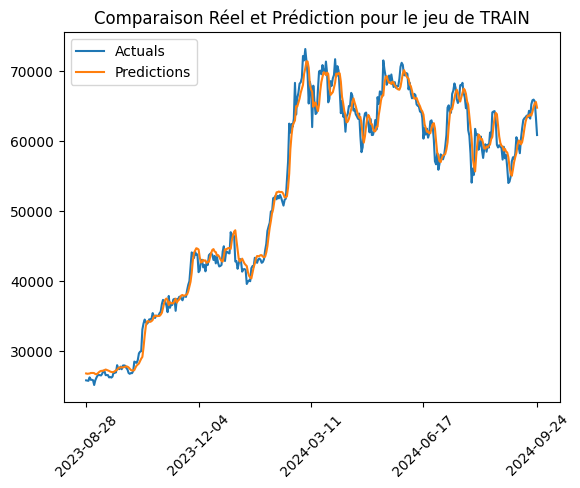

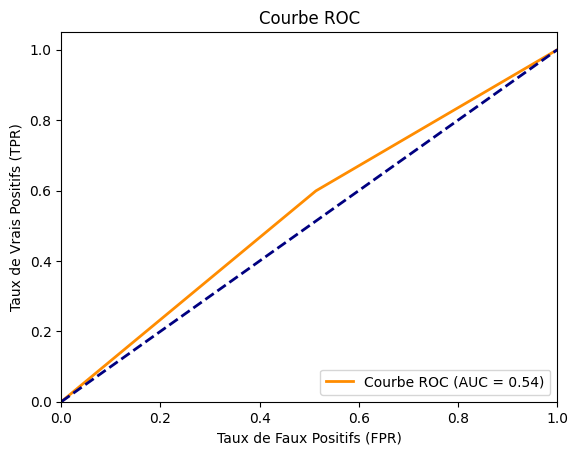

2/2 [==============================] - 0s 7ms/step
#####VAL#####
          Date    Actual N+7    Actual N+8  Predictions N+8  Actual UP or DOWN  Predicted UP or DOWN
0  2024-09-25  60825.742188  60649.281250     62899.023438                  0                     1
1  2024-09-26  60662.730469  60752.710938     61756.257812                  1                     1
2  2024-09-27  60770.464844  62086.000000     61343.695312                  1                     1
3  2024-09-28  62159.273438  62058.000000     61439.953125                  0                     0
4  2024-09-29  62130.113281  62819.910156     61707.375000                  1                     0
5  2024-09-30  62923.750000  62224.000000     62165.687500                  0                     0
6  2024-10-01  62303.027344  62160.488281     62338.832031                  0                     1
--Regression Metrics--
R^2 = 93.9010739326477%
MAE = 1754.4681396484375
MSE = 5732944.5
RMSE = 2394.3568029848852
MAPE = 2.40017194300

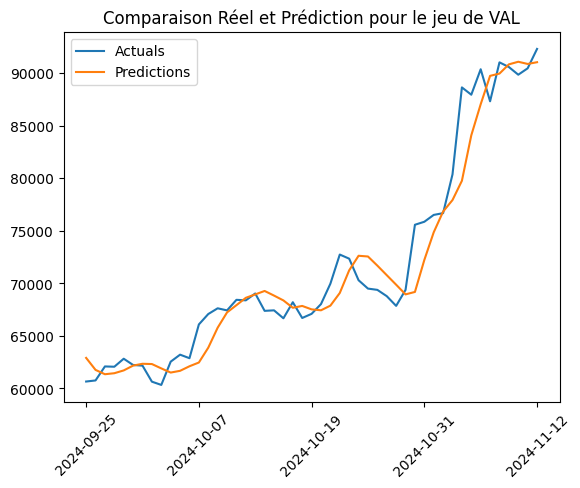

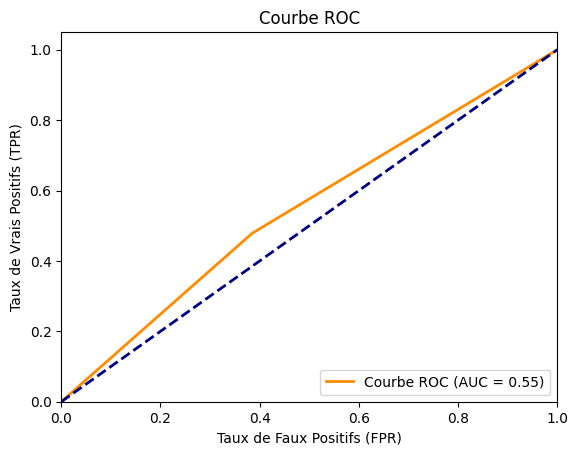

2/2 [==============================] - 0s 7ms/step
#####TEST#####
          Date     Actual N+7    Actual N+8  Predictions N+8  Actual UP or DOWN  Predicted UP or DOWN
0  2024-11-13   95720.609375  94286.562500     94831.703125                  0                     0
1  2024-11-14   97209.007812  98317.117188     96075.312500                  1                     0
2  2024-11-15  100245.312500  98892.000000     98098.898438                  0                     0
3  2024-11-16  100678.382812  97672.398438     99823.757812                  0                     0
4  2024-11-17   99759.625000  97900.039062    100443.617188                  0                     1
5  2024-11-18   99931.117188  93010.007812    100560.210938                  0                     1
6  2024-11-19   96247.351562  91965.156250     98948.351562                  0                     1
--Regression Metrics--
R^2 = -14.841794967651367%
MAE = 2617.44482421875
MSE = 11049510.0
RMSE = 3324.0803239392394
MAPE = 2.

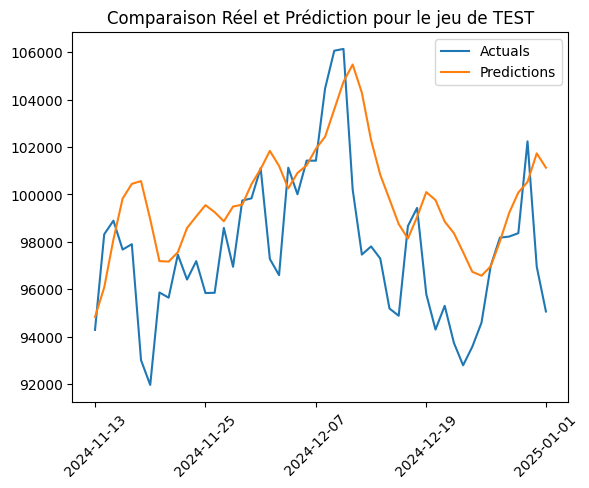

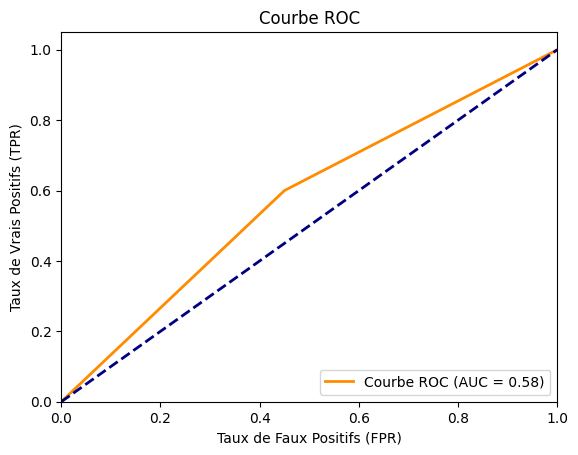

In [198]:
main_analyze_model_close_price(full_model_name, WINDOW_SIZE)

### Modèle 2: Close_price sur les données du 2017-08-17 au 2025-01-08

In [199]:
"""
preprocess2 les données data_name et entraine un modele model_name
"""
WINDOW_SIZE = 7
N_EPOCHS = 100
data_name = "dataset_raw_1d_2017_08_17_2025_01_08"    

#datasets = main_pre_processing_close_price(data_name, WINDOW_SIZE)

model_name = f"Model2_Close_price_jaquart_dense64_WS{WINDOW_SIZE}"
full_model_name = model_name+'-'+data_name+'-'+str(N_EPOCHS)

# X_train = datasets['TRAIN'][0][1]
# y_train = datasets['TRAIN'][0][2]

# X_val = datasets['VAL'][0][1]
# y_val = datasets['VAL'][0][2]

#main_training_model(full_model_name, X_train, y_train, X_val, y_val, WINDOW_SIZE, N_EPOCHS)

X.shape (2700, 7, 1)
y.shape (2700, 1)
X_train_norm.shape (2160, 7, 1)
y_train_norm.shape (2160, 1)
68/68 [==============================] - 1s 6ms/step
#####TRAIN#####
          Date   Actual N+7   Actual N+8  Predictions N+8  Actual UP or DOWN  Predicted UP or DOWN
0  2017-08-17  4114.009766  4316.009766      4720.758301                  1                     1
1  2017-08-18  4316.009766  4280.680176      4808.075195                  0                     1
2  2017-08-19  4280.680176  4337.439941      4862.445312                  1                     1
3  2017-08-20  4337.439941  4310.009766      4916.705566                  0                     1
4  2017-08-21  4310.009766  4386.689941      4940.649902                  1                     1
5  2017-08-22  4386.689941  4587.479980      4977.998535                  1                     1
6  2017-08-23  4587.479980  4555.140137      5072.939941                  0                     1
--Regression Metrics--
R^2 = 99.43540692329407

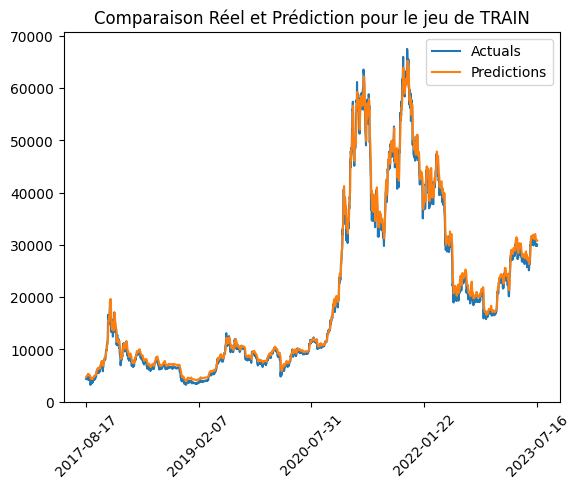

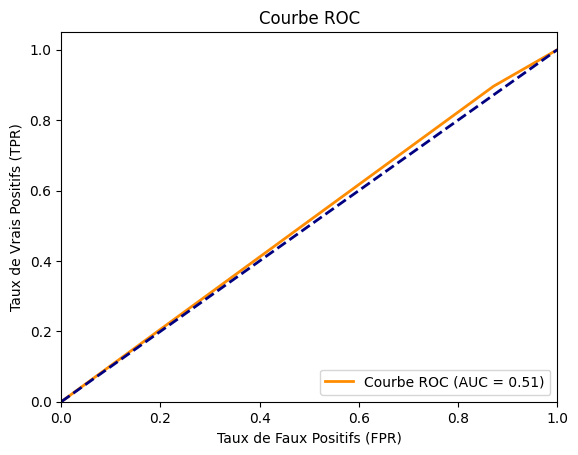

9/9 [==============================] - 0s 6ms/step
#####VAL#####
          Date    Actual N+7    Actual N+8  Predictions N+8  Actual UP or DOWN  Predicted UP or DOWN
0  2023-07-17  30083.750000  29176.500000     30170.310547                  0                     1
1  2023-07-18  29176.500000  29228.910156     29922.103516                  1                     1
2  2023-07-19  29228.910156  29351.960938     29748.544922                  1                     1
3  2023-07-20  29351.960938  29222.779297     29678.791016                  0                     1
4  2023-07-21  29222.779297  29314.140625     29602.628906                  1                     1
5  2023-07-22  29314.140625  29352.900391     29590.902344                  1                     1
6  2023-07-23  29352.900391  29281.089844     29606.673828                  0                     1
--Regression Metrics--
R^2 = 99.07152056694031%
MAE = 962.6051635742188
MSE = 1913348.25
RMSE = 1383.2383200302108
MAPE = 2.2326318547

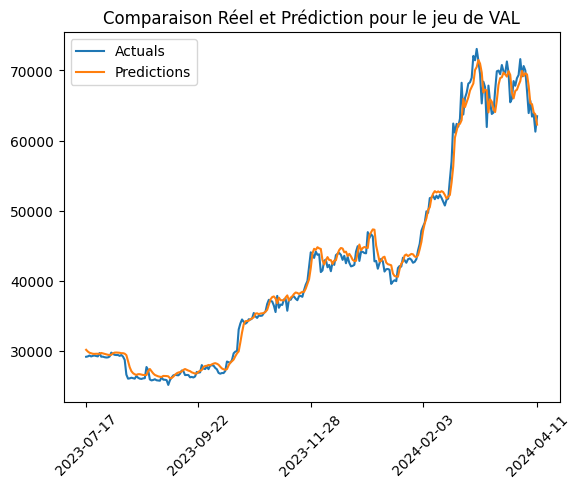

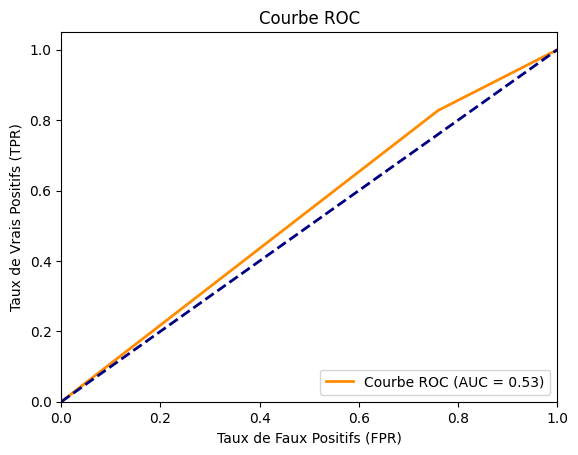

9/9 [==============================] - 0s 6ms/step
#####TEST#####
          Date    Actual N+7    Actual N+8  Predictions N+8  Actual UP or DOWN  Predicted UP or DOWN
0  2024-04-12  63470.082031  63818.007812     63105.695312                  1                     0
1  2024-04-13  63818.007812  64940.589844     63501.140625                  1                     0
2  2024-04-14  64940.589844  64941.148438     64385.476562                  1                     0
3  2024-04-15  64941.148438  66819.320312     64963.414062                  1                     1
4  2024-04-16  66819.320312  66414.000000     66275.539062                  0                     0
5  2024-04-17  66414.000000  64289.589844     66827.851562                  0                     1
6  2024-04-18  64289.589844  64498.339844     65899.812500                  1                     1
--Regression Metrics--
R^2 = 97.88738489151001%
MAE = 1644.0872802734375
MSE = 4438852.5
RMSE = 2106.8584432752
MAPE = 2.338956855237

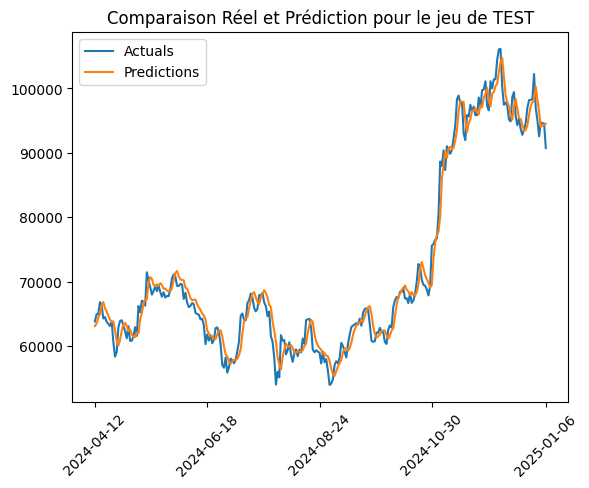

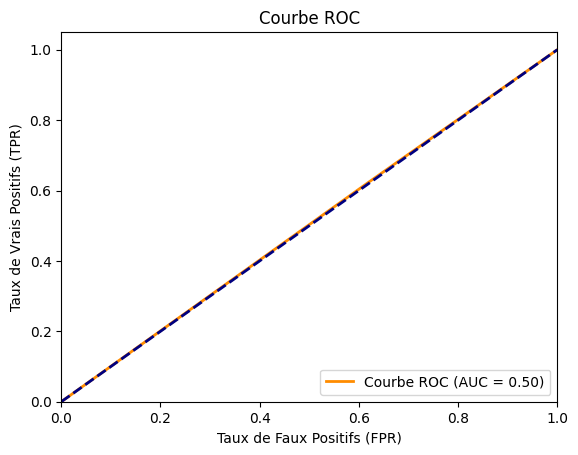

In [200]:
main_analyze_model_close_price(full_model_name, WINDOW_SIZE)

### Modèle 3: Log_close_price sur les données du 2017-08-17 au 2025-01-08

In [201]:
"""
preprocess2 les données data_name et entraine un modele model_name
"""
WINDOW_SIZE = 7
N_EPOCHS = 100
data_name = "dataset_raw_1d_2017_08_17_2025_01_08"    

#datasets = main_pre_processing_log_close_price(data_name, WINDOW_SIZE)

model_name = f"Model2_Log_close_price_jaquart_dense64_WS{WINDOW_SIZE}"
full_model_name = model_name+'-'+data_name+'-'+str(N_EPOCHS)

# X_train = datasets['TRAIN'][0][1]
# y_train = datasets['TRAIN'][0][2]

# X_val = datasets['VAL'][0][1]
# y_val = datasets['VAL'][0][2]

#main_training_model(full_model_name, X_train, y_train, X_val, y_val, WINDOW_SIZE, N_EPOCHS)

X.shape (2700, 7, 1)
y.shape (2700, 1)
X_train_norm.shape (2160, 7, 1)
y_train_norm.shape (2160, 1)
68/68 [==============================] - 1s 6ms/step
#####TRAIN#####
          Date   Actual N+7   Actual N+8  Predictions N+8  Actual UP or DOWN  Predicted UP or DOWN
0  2017-08-17  4114.008301  4316.009766      4181.796875                  1                     1
1  2017-08-18  4316.009766  4280.679199      4319.370117                  0                     1
2  2017-08-19  4280.679199  4337.441895      4372.732910                  1                     1
3  2017-08-20  4337.441895  4310.008789      4428.658691                  0                     1
4  2017-08-21  4310.008789  4386.691406      4437.088867                  1                     1
5  2017-08-22  4386.691406  4587.481934      4479.388184                  1                     1
6  2017-08-23  4587.481934  4555.138672      4611.215820                  0                     1
--Regression Metrics--
R^2 = 99.3445336818695%

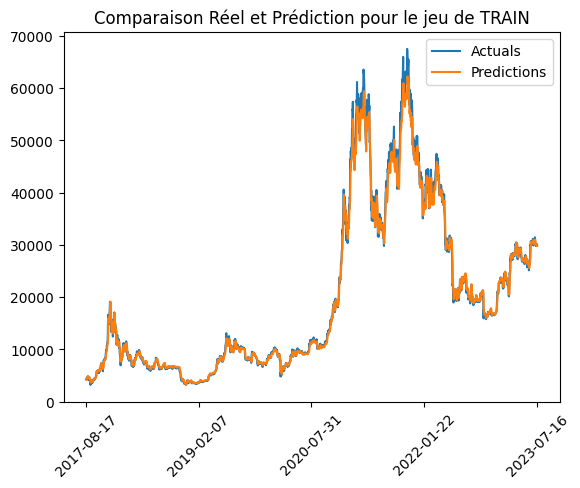

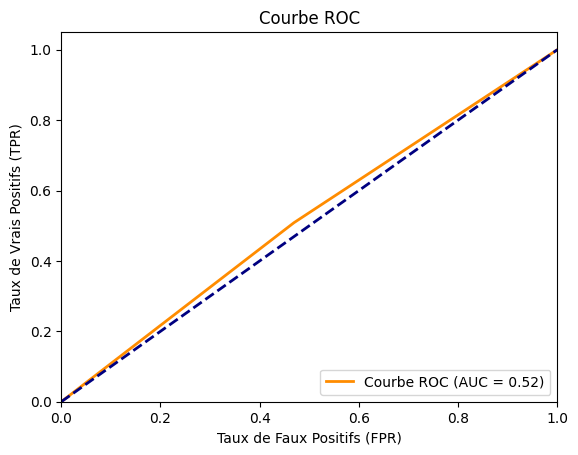

9/9 [==============================] - 0s 6ms/step
#####VAL#####
          Date    Actual N+7    Actual N+8  Predictions N+8  Actual UP or DOWN  Predicted UP or DOWN
0  2023-07-17  30083.763672  29176.484375     30260.175781                  0                     1
1  2023-07-18  29176.484375  29228.898438     29844.183594                  1                     1
2  2023-07-19  29228.898438  29351.947266     29648.273438                  1                     1
3  2023-07-20  29351.947266  29222.769531     29622.751953                  0                     1
4  2023-07-21  29222.769531  29314.152344     29552.970703                  1                     1
5  2023-07-22  29314.152344  29352.898438     29575.724609                  1                     1
6  2023-07-23  29352.898438  29281.099609     29615.183594                  0                     1
--Regression Metrics--
R^2 = 99.02293682098389%
MAE = 928.3506469726562
MSE = 2013467.0
RMSE = 1418.9668776965866
MAPE = 2.03144103288

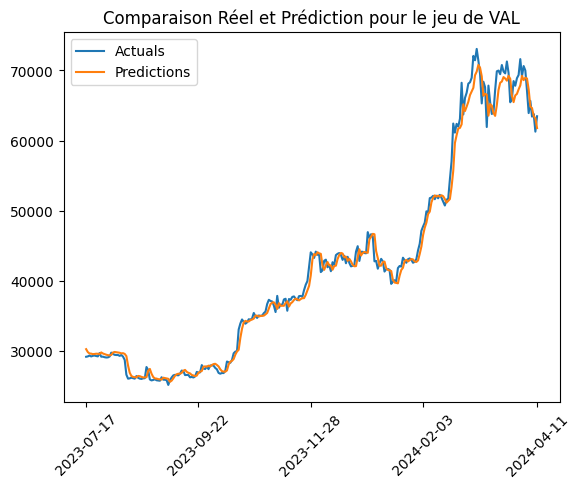

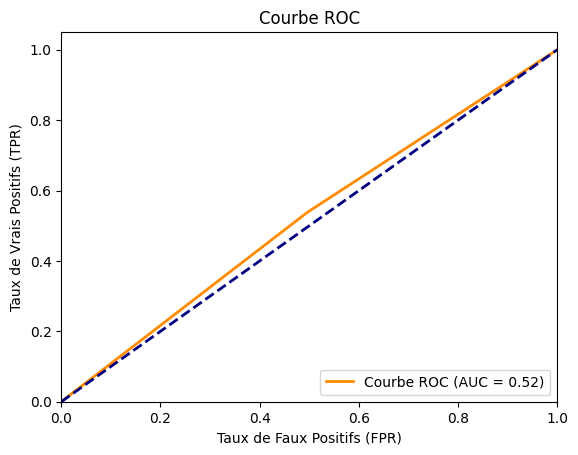

9/9 [==============================] - 0s 7ms/step
#####TEST#####
          Date    Actual N+7    Actual N+8  Predictions N+8  Actual UP or DOWN  Predicted UP or DOWN
0  2024-04-12  63470.078125  63817.984375     63172.062500                  1                     0
1  2024-04-13  63817.984375  64940.531250     63639.238281                  1                     0
2  2024-04-14  64940.531250  64941.152344     64455.941406                  1                     0
3  2024-04-15  64941.152344  66819.343750     64893.238281                  1                     0
4  2024-04-16  66819.343750  66414.015625     65995.984375                  0                     0
5  2024-04-17  66414.015625  64289.574219     66347.101562                  0                     0
6  2024-04-18  64289.574219  64498.371094     65411.125000                  1                     1
--Regression Metrics--
R^2 = 97.9826271533966%
MAE = 1552.306884765625
MSE = 4238736.0
RMSE = 2058.8190789867867
MAPE = 2.17011477798

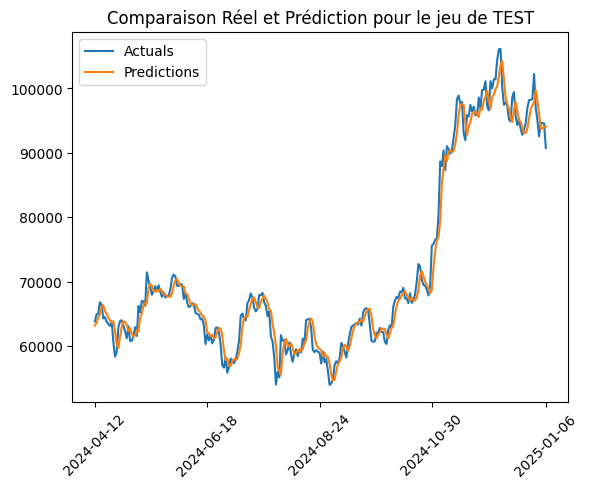

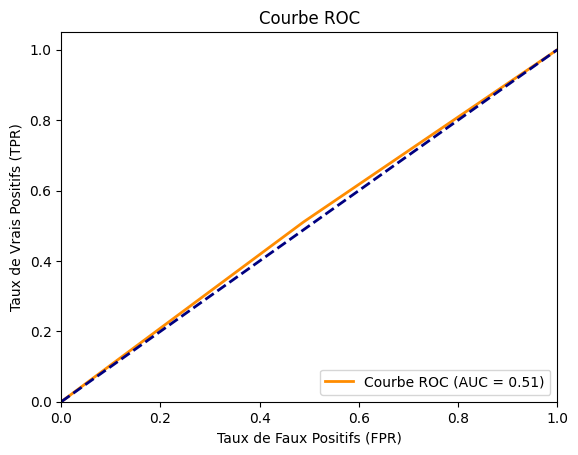

In [202]:
main_analyze_model_log_close_price(full_model_name, WINDOW_SIZE)

### Modèle 4:  dataset_v2 avec log_close_price sur les données du 2017-08-17 au 2025-01-08

In [203]:
"""
preprocess2 les données data_name et entraine un modele model_name
"""
WINDOW_SIZE = 7
N_EPOCHS = 100
data_name = "dataset_v2_1d_2017_08_17_2025_01_08"    

#datasets = main_pre_processing_multivar(data_name, WINDOW_SIZE)

model_name = f"Model2_Log_close_price_jaquart_dense64_WS{WINDOW_SIZE}"
full_model_name = model_name+'-'+data_name+'-'+str(N_EPOCHS)

# X_train = datasets['TRAIN'][0][1]
# y_train = datasets['TRAIN'][0][2]

# X_val = datasets['VAL'][0][1]
# y_val = datasets['VAL'][0][2]

#main_training_model(full_model_name, X_train, y_train, X_val, y_val, WINDOW_SIZE, N_EPOCHS)

Index(['log_close_price', 'Open_price', 'High_price', 'Low_price', 'Volume',
       'Quote_volume', 'Nb_trades', 'Taker_buy_base_volume',
       'Taker_buy_quote_volume', 'evolution_prct', 'lundi', 'mardi',
       'mercredi', 'jeudi', 'vendredi', 'samedi', 'dimanche', 'janvier',
       'fevrier', 'mars', 'avril', 'mai', 'juin', 'juillet', 'aout',
       'septembre', 'octobre', 'novembre', 'decembre', 'RSI', 'EMA_14', 'MACD',
       'MACD_Signal'],
      dtype='object')
X.shape (2667, 7, 33)
y.shape (2667,)
X_train_norm.shape (2133, 7, 33)
y_train_norm.shape (2133, 1)
67/67 [==============================] - 1s 6ms/step
#####TRAIN#####
          Date   Actual N+7   Actual N+8  Predictions N+8  Actual UP or DOWN  Predicted UP or DOWN
0  2017-09-19  3920.750244  3882.351807      4078.833008                  0                     1
1  2017-09-20  3882.351807  4193.001953      4118.604980                  1                     1
2  2017-09-21  4193.001953  4174.500977      4324.980469      

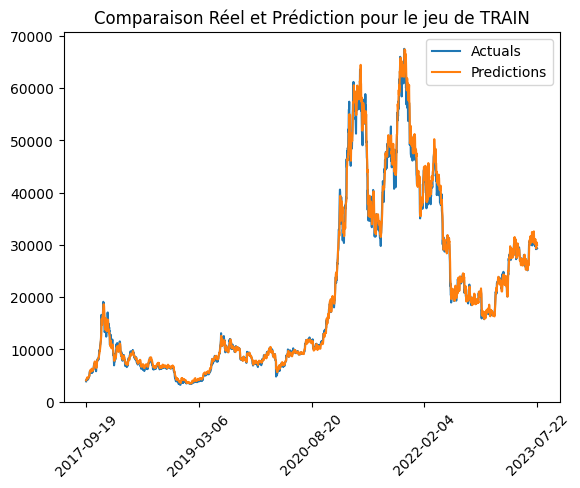

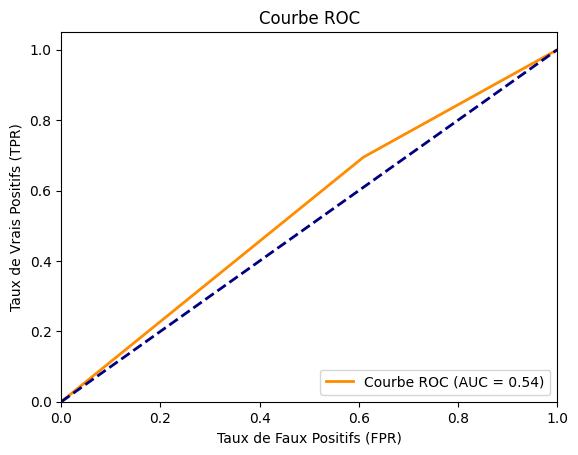

9/9 [==============================] - 0s 6ms/step
#####VAL#####
          Date    Actual N+7    Actual N+8  Predictions N+8  Actual UP or DOWN  Predicted UP or DOWN
0  2023-07-23  29352.898438  29281.099609     31632.742188                  0                     1
1  2023-07-24  29281.099609  29232.244141     31661.503906                  0                     1
2  2023-07-25  29232.244141  29705.980469     31392.980469                  1                     1
3  2023-07-26  29705.980469  29186.001953     32011.509766                  0                     1
4  2023-07-27  29186.001953  29193.628906     31626.919922                  1                     1
5  2023-07-28  29193.628906  29114.003906     31627.974609                  0                     1
6  2023-07-29  29114.003906  29072.134766     31347.298828                  0                     1
--Regression Metrics--
R^2 = 90.17068147659302%
MAE = 3685.806884765625
MSE = 20673202.0
RMSE = 4546.779299680159
MAPE = 8.82919654250

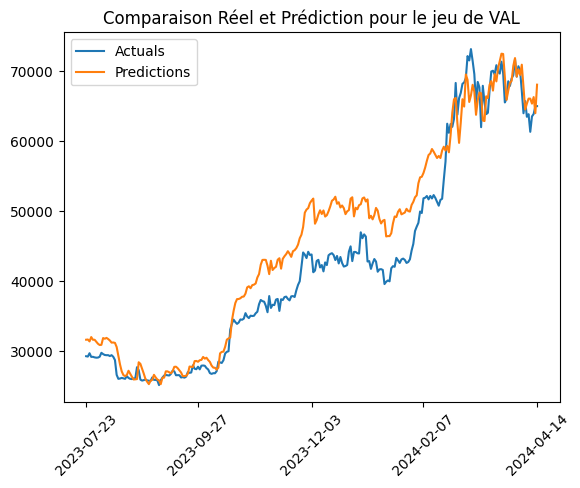

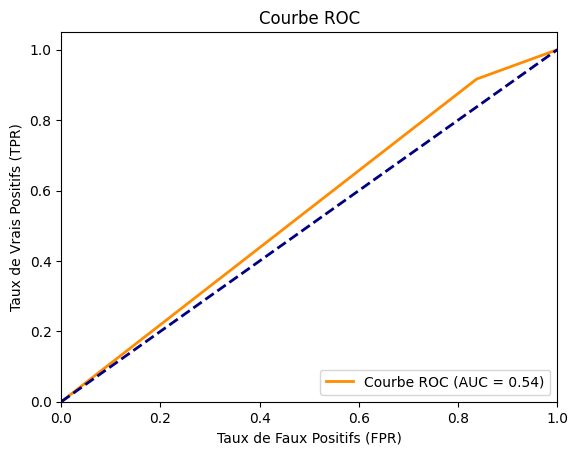

9/9 [==============================] - 0s 7ms/step
#####TEST#####
          Date    Actual N+7    Actual N+8  Predictions N+8  Actual UP or DOWN  Predicted UP or DOWN
0  2024-04-15  64941.152344  66819.343750     70835.773438                  1                     1
1  2024-04-16  66819.343750  66414.015625     73314.859375                  0                     1
2  2024-04-17  66414.015625  64289.574219     74674.281250                  0                     1
3  2024-04-18  64289.574219  64498.371094     72540.359375                  1                     1
4  2024-04-19  64498.371094  63769.984375     72353.812500                  0                     1
5  2024-04-20  63769.984375  63461.964844     70589.296875                  0                     1
6  2024-04-21  63461.964844  63118.648438     69623.265625                  0                     1
--Regression Metrics--
R^2 = 82.78682827949524%
MAE = 5374.03076171875
MSE = 36478156.0
RMSE = 6039.714893933322
MAPE = 7.95096233487

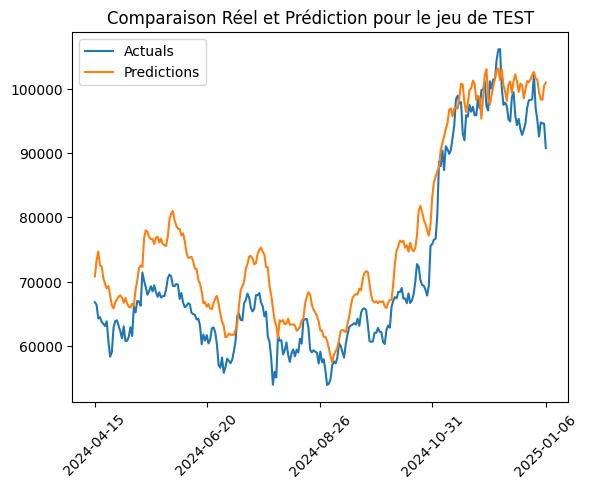

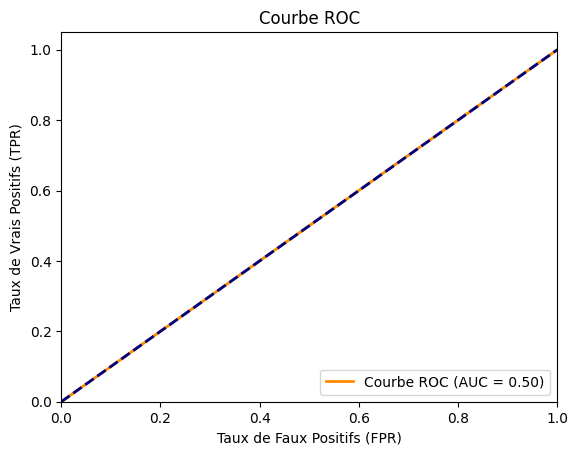

In [204]:
main_analyze_model_multivar(full_model_name, WINDOW_SIZE)